# Data preparation

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import joblib
warnings.filterwarnings("ignore")

In [40]:
data = "engine_data.csv"

In [41]:
df = pd.read_csv(data)

# EDA

In [42]:
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [43]:
df.isnull().sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
Engine Condition    0
dtype: int64

In [57]:
df.dtypes

engine_rpm            int64
lub_oil_pressure    float64
fuel_pressure       float64
coolant_pressure    float64
lub_oil_temp        float64
coolant_temp        float64
engine_condition      int64
dtype: object

In [58]:
df.describe()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
count,19535.0000,19535.0000,19535.0000,19535.0000,19535.0000,19535.0000,19535.0000
mean,791.2393,3.3038,6.6556,2.3354,77.6434,78.4274,0.6305
std,267.6112,1.0216,2.7610,1.0364,3.1110,6.2067,0.4827
min,61.0000,0.0034,0.0032,0.0025,71.3220,61.6733,0.0000
25%,593.0000,2.5188,4.9169,1.6005,75.7260,73.8954,0.0000
50%,746.0000,3.1620,6.2017,2.1669,76.8174,78.3467,1.0000
75%,934.0000,4.0553,7.7450,2.8488,78.0717,82.9154,1.0000
max,2239.0000,7.2656,21.1383,7.4785,89.5808,195.5279,1.0000


In [44]:
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

In [45]:
df.head()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [46]:
X = df.drop("engine_condition", axis=1)
y = df["engine_condition"]

In [47]:
y = y.astype(int)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
binary_classification = len(np.unique(y)) == 2
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1": make_scorer(f1_score, average="weighted", zero_division=0)
}
if binary_classification:
    scoring["roc_auc"] = make_scorer(roc_auc_score, needs_proba=True)

In [51]:
models_and_grids = {
    "Logistic Regression": {
        "estimator": Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(max_iter=1000))
        ]),
        "param_grid": {
            "model__C": [0.01, 0.1, 1, 10],
            "model__solver": ["lbfgs", "liblinear"]
        }
    },
    "Decision Tree": {
        "estimator": DecisionTreeClassifier(random_state=42),
        "param_grid": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "criterion": ["gini", "entropy"]
        }
    },
    "Random Forest": {
        "estimator": RandomForestClassifier(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
            "bootstrap": [True, False]
        }
    },
    "XGBoost": {
        "estimator": xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0]
        }
    }
}

In [54]:
results = []
best_models = {}

for name, entry in models_and_grids.items():
    print(f"\n--- Tuning {name} ---")
    estimator = entry["estimator"]
    param_grid = entry["param_grid"]

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",   # tune for accuracy; change if you prefer other metric
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    # Fit grid on the training data only
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    best_models[name] = best
    print("best params:", grid.best_params_)
    # Cross-validated performance of best estimator (on training data, internal CV)
    # We'll compute CV metrics (accuracy, precision, recall, f1, roc_auc if binary)
    # Note: we use cross_val_score on X_train to estimate expected performance
    cv_acc = cross_val_score(best, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    cv_prec = cross_val_score(best, X_train, y_train, cv=cv,
                              scoring='precision_weighted', n_jobs=-1).mean()
    cv_rec = cross_val_score(best, X_train, y_train, cv=cv,
                             scoring='recall_weighted', n_jobs=-1).mean()
    cv_f1 = cross_val_score(best, X_train, y_train, cv=cv,
                            scoring='f1_weighted', n_jobs=-1).mean()

    if binary_classification:
        # roc_auc (binary) using predict_proba
        try:
            cv_roc = cross_val_score(best, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
        except Exception:
            cv_roc = np.nan
    else:
        cv_roc = np.nan

    # Now evaluate on the held-out test set
    y_pred = best.predict(X_test)
    # predict_proba maybe not available for all wrappers; handle gracefully
    y_prob = None
    try:
        proba = best.predict_proba(X_test)
        if binary_classification:
            y_prob = proba[:, 1]
    except Exception:
        y_prob = None

    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    test_rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    test_roc = roc_auc_score(y_test, y_prob) if (binary_classification and y_prob is not None) else np.nan

    results.append({
        "Model": name,
        "CV_accuracy": cv_acc,
        "CV_precision": cv_prec,
        "CV_recall": cv_rec,
        "CV_f1": cv_f1,
        "CV_roc_auc": cv_roc,
        "Test_accuracy": test_acc,
        "Test_precision": test_prec,
        "Test_recall": test_rec,
        "Test_f1": test_f1,
        "Test_roc_auc": test_roc
    })


--- Tuning Logistic Regression ---
best params: {'model__C': 0.1, 'model__solver': 'lbfgs'}

--- Tuning Decision Tree ---
best params: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

--- Tuning Random Forest ---
best params: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

--- Tuning XGBoost ---
best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [55]:
results_df = pd.DataFrame(results).sort_values(by="Test_accuracy", ascending=False).reset_index(drop=True)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")
print("\nFinal comparison (sorted by Test accuracy):\n")
print(results_df)


Final comparison (sorted by Test accuracy):

                 Model  CV_accuracy  CV_precision  CV_recall  CV_f1  \
0              XGBoost       0.6704        0.6557     0.6704 0.6513   
1        Random Forest       0.6676        0.6520     0.6676 0.6457   
2  Logistic Regression       0.6616        0.6440     0.6616 0.6275   
3        Decision Tree       0.6631        0.6480     0.6631 0.6424   

   CV_roc_auc  Test_accuracy  Test_precision  Test_recall  Test_f1  \
0      0.7000         0.6660          0.6502       0.6660   0.6457   
1      0.6966         0.6627          0.6458       0.6627   0.6395   
2      0.6882         0.6611          0.6434       0.6611   0.6261   
3      0.6785         0.6598          0.6427       0.6598   0.6382   

   Test_roc_auc  
0        0.7019  
1        0.6989  
2        0.6918  
3        0.6822  


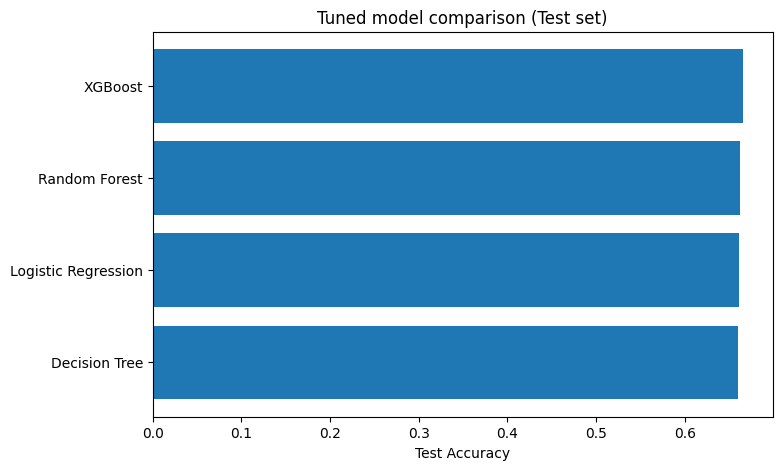

In [56]:
plt.figure(figsize=(8,5))
plt.barh(results_df["Model"], results_df["Test_accuracy"])
plt.xlabel("Test Accuracy")
plt.title("Tuned model comparison (Test set)")
plt.gca().invert_yaxis()
plt.show()

In [59]:
importances = best_models["XGBoost"].feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
importance_df.sort_values(by="Importance", ascending=False).head(10)

,Feature,Importance
0,engine_rpm,0.5144
2,fuel_pressure,0.1743
4,lub_oil_temp,0.1038
1,lub_oil_pressure,0.0883
3,coolant_pressure,0.0634
5,coolant_temp,0.0559


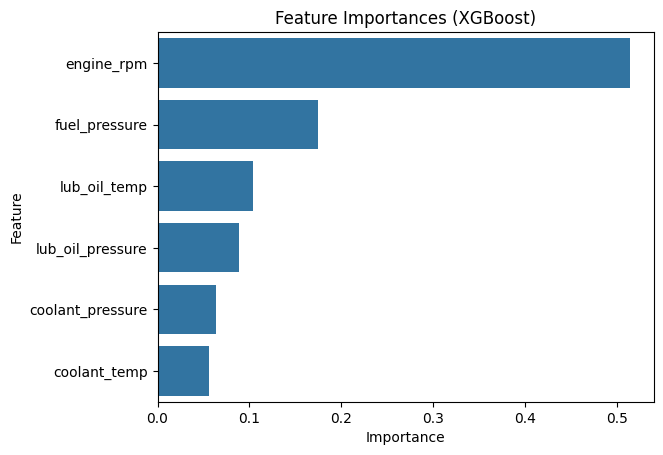

In [63]:
sns.barplot(x="Importance", y="Feature", data=importance_df.sort_values("Importance", ascending=False))
plt.title("Feature Importances (XGBoost)")
plt.show()

In [ ]:
model_filename = 'model.bin'
joblib.dump(best_models["XGBoost"], model_filename)
print(f"✓ Model saved to '{model_filename}'")

✓ Model saved to 'xgboost_engine_model.bin'


In [66]:
loaded_model = joblib.load(model_filename)
test_prediction = loaded_model.predict(X_test[:5])
print(f"✓ Model loaded successfully. Sample predictions: {test_prediction}")

✓ Model loaded successfully. Sample predictions: [1 1 1 1 1]
